# 中期负荷预测分析

In [5]:
import pandas as pd
df = pd.read_csv('prediction_long.csv',header=1)
dates_to_remove = ['2024-03-15','2024-03-14','2024-03-18','2024-03-19','2024-03-16','2024-03-17','2024-03-20']
df['日期'] = pd.to_datetime(df['日期'])
df = df[~df['日期'].isin(pd.to_datetime(dates_to_remove))]
df.reset_index(drop=True, inplace=True)
df

,日期,清华预测,硕能预测
0,2023-12-04,92.2,96.6
1,2023-12-05,95.2,97.7
2,2023-12-06,96.1,93.8
3,2023-12-07,96.0,96.6
4,2023-12-08,97.6,92.2
...,...,...,...
145,2024-06-06,96.1,98.2
146,2024-06-07,97.4,98.0
147,2024-06-08,98.2,96.9
148,2024-06-09,95.2,98.1


## 精确度趋势折线图

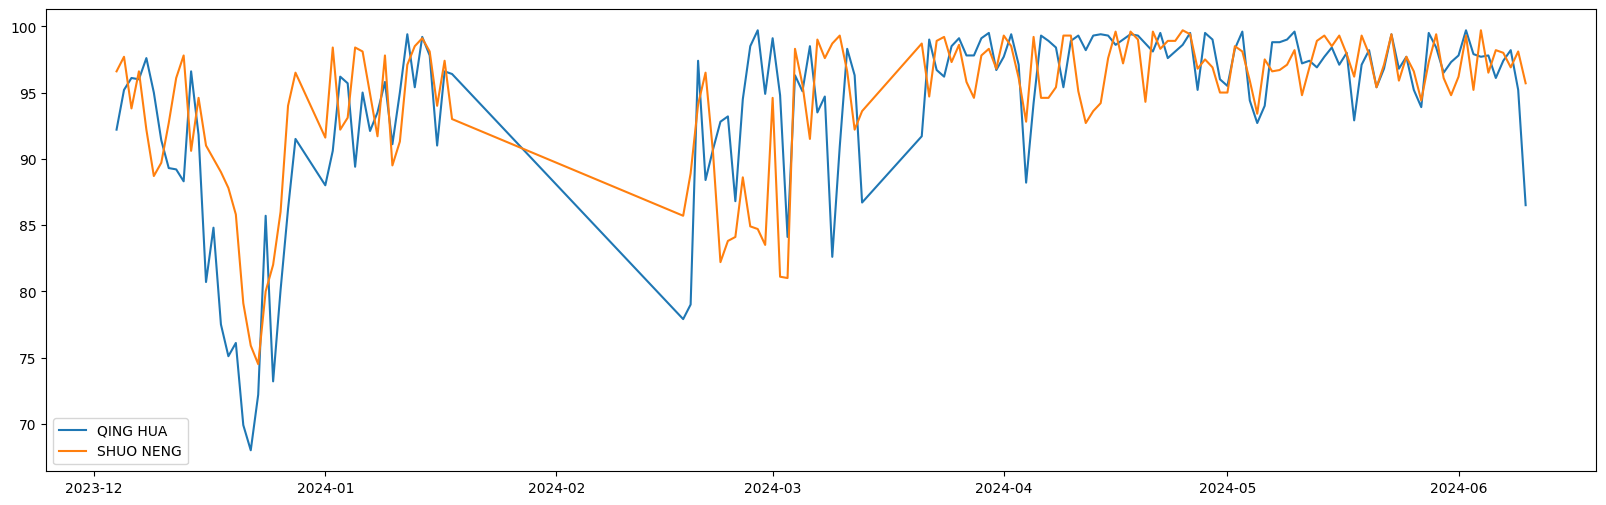

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20,6))
plt.plot(df['日期'],df['清华预测'],label='QING HUA')
plt.plot(df['日期'],df['硕能预测'],label='SHUO NENG')
plt.legend()
plt.show()

## 总平均准确率对比

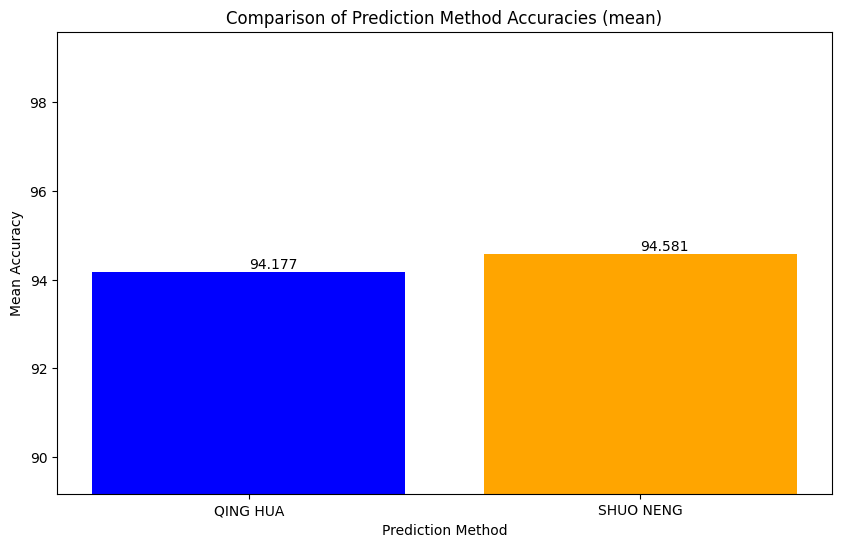

In [12]:
mean_qinghua = df['清华预测'].mean()
mean_shuoneng = df['硕能预测'].mean()
methods = ['QING HUA','SHUO NENG']
accuracies = [mean_qinghua,mean_shuoneng]
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies, color=['blue', 'orange'])
plt.xlabel('Prediction Method')
plt.ylabel('Mean Accuracy')
plt.title('Comparison of Prediction Method Accuracies (mean)')
min_accuracy = min(accuracies) - 5
max_accuracy = max(accuracies) + 5
plt.ylim(min_accuracy, max_accuracy)
for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(accuracy, 3), va='bottom')
plt.show()

## 预测稳定性分析

In [11]:
statistics = {
    '系统': ['清华', '硕能'],
    '平均值': [df['清华预测'].mean(),df['硕能预测'].mean()],
    '标准差': [df['清华预测'].std(), df['硕能预测'].std()],
    '最小值': [df['清华预测'].min(), df['硕能预测'].min()],
    '最大值': [df['清华预测'].max(), df['硕能预测'].max()],
    '中位数': [df['清华预测'].median(), df['硕能预测'].median()],
    '范围': [df['清华预测'].max() - df['清华预测'].min(),  
              df['硕能预测'].max() - df['硕能预测'].min()]
}

statistics_df = pd.DataFrame(statistics)

statistics_df

,系统,平均值,标准差,最小值,最大值,中位数,范围
0,清华,94.177333,6.564273,68.0,99.7,96.55,31.7
1,硕能,94.580667,5.235907,74.5,99.7,96.50,25.2


## 月准确率&赢率对比分析

In [13]:
df.loc[:, '月份'] = df['日期'].dt.to_period('M')
def Range(x):
    return x.max() - x.min()
monthly_avg = df.groupby('月份').agg({
    '清华预测': ['mean', 'max', 'min', 'median', Range],
    '硕能预测': ['mean', 'max', 'min', 'median', Range]
}).reset_index()

monthly_avg

月份       清华预测                                硕能预测                     \
                 mean   max   min median Range       mean   max   min median   
0  2023-12  85.588000  97.6  68.0  88.30  29.6  89.548000  97.8  74.5  90.60   
1  2024-01  94.344444  99.4  88.0  95.20  11.4  95.233333  99.1  89.5  96.00   
2  2024-02  91.150000  99.7  77.9  93.00  21.8  87.291667  96.5  82.2  85.30   
3  2024-03  95.125000  99.5  82.6  96.50  16.9  95.408333  99.3  81.0  97.05   
4  2024-04  97.970000  99.5  88.2  98.80  11.3  97.100000  99.7  92.7  97.55   
5  2024-05  97.048387  99.6  92.7  97.30   6.9  97.100000  99.4  93.4  97.10   
6  2024-06  96.430000  99.7  86.5  97.75  13.2  97.380000  99.7  95.2  97.45   

         
  Range  
0  23.3  
1   9.6  
2  14.3  
3  18.3  
4   7.0  
5   6.0  
6   4.5

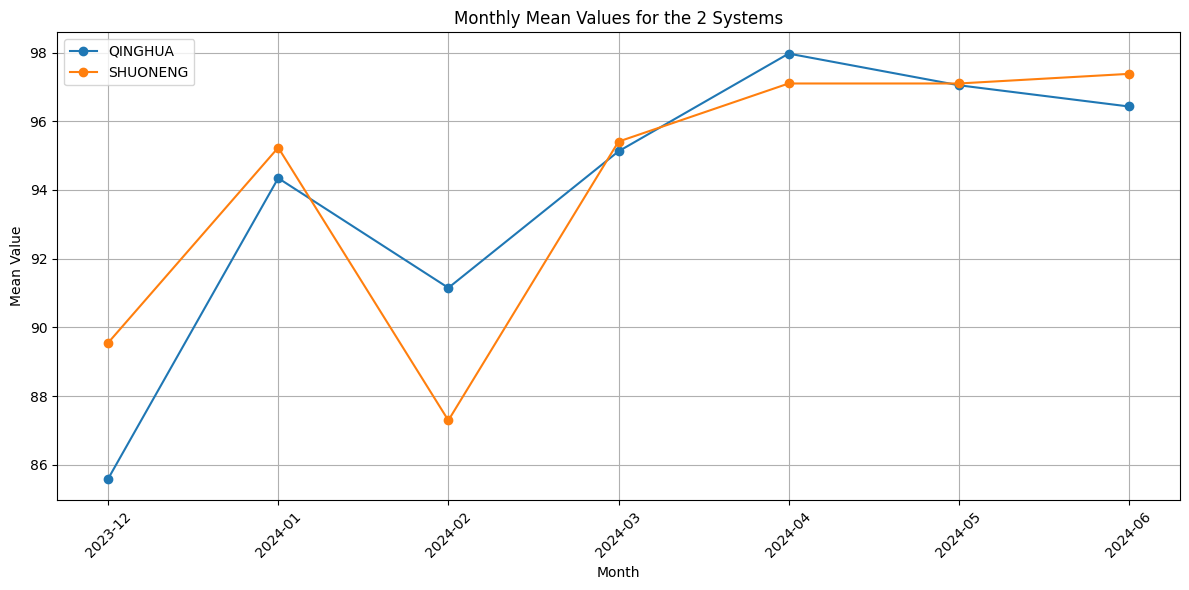

In [17]:

months = monthly_avg['月份'].astype(str)
mean_qinghua = monthly_avg['清华预测']['mean']
mean_shuonen = monthly_avg['硕能预测']['mean']

plt.figure(figsize=(12, 6))
plt.plot(months, mean_qinghua, marker='o', label='QINGHUA')
plt.plot(months, mean_shuonen, marker='o', label='SHUONENG')

plt.title('Monthly Mean Values for the 2 Systems')
plt.xlabel('Month')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [18]:
#月赢率
win_counter = {'QING HUA':0,'SHUO NENG':0}
results = []
for i, row in df.iterrows():
    accuracies = {
        'QING HUA': row['清华预测'],
        'SHUO NENG': row['硕能预测']
    }
    winner = max(accuracies, key=accuracies.get)
    win_counter[winner] += 1
    d = {'日期':row['日期'],'Winner':winner}
    results.append(d)
results = pd.DataFrame(results)

results['月份'] = results['日期'].dt.to_period('M')
monthly_win_rates = results.groupby('月份')['Winner'].value_counts(normalize=True).unstack().fillna(0) * 100
monthly_win_rates.columns = ['QING HUA Win Rate', 'SHUO NENG Win Rate']
monthly_win_rates


,QING HUA Win Rate,SHUO NENG Win Rate
月份,,
2023-12,24.000000,76.000000
2024-01,44.444444,55.555556
2024-02,75.000000,25.000000
2024-03,54.166667,45.833333
2024-04,60.000000,40.000000
2024-05,54.838710,45.161290
2024-06,50.000000,50.000000


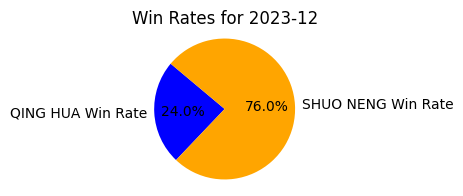

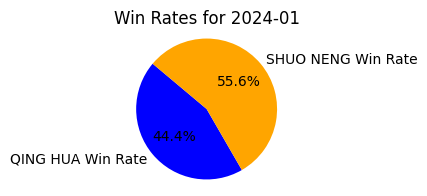

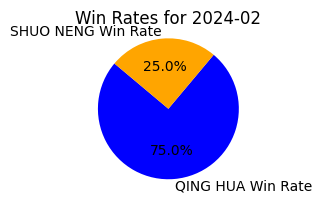

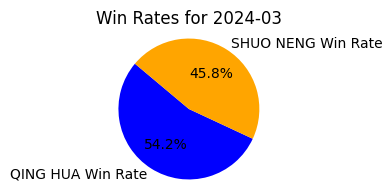

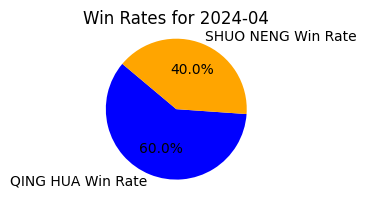

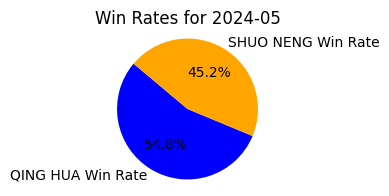

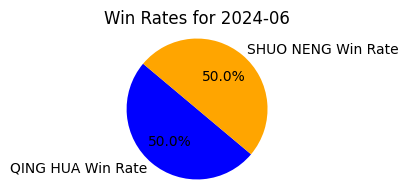

In [21]:
for month, row in monthly_win_rates.iterrows():
    labels = row.index
    sizes = row.values
    colors = ['blue', 'orange']
    
    plt.figure(figsize=(2, 2))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(f'Win Rates for {month}')
    plt.axis('equal')
    plt.show()

## 周&日赢率

In [22]:
results['周'] = results['日期'].dt.to_period('W')
weekly_win_rates = results.groupby('周')['Winner'].value_counts(normalize=True).unstack().fillna(0) * 100
weekly_win_rates.columns = ['QING HUA Win Rate','SHUO NENG Win Rate']

weekly_win_rates

,QING HUA Win Rate,SHUO NENG Win Rate
周,,
2023-12-04/2023-12-10,57.142857,42.857143
2023-12-11/2023-12-17,14.285714,85.714286
2023-12-18/2023-12-24,14.285714,85.714286
2023-12-25/2023-12-31,0.000000,100.000000
2024-01-01/2024-01-07,28.571429,71.428571
2024-01-08/2024-01-14,71.428571,28.571429
2024-01-15/2024-01-21,25.000000,75.000000
2024-02-12/2024-02-18,0.000000,100.000000
2024-02-19/2024-02-25,71.428571,28.571429


In [23]:
results['日期'] = results['日期'].dt.to_period('D')
daily_win_rates = results.groupby('日期')['Winner'].value_counts(normalize=True).unstack().fillna(0) * 1
daily_win_rates.columns = ['QING HUA Win Rate', 'SHUO NENG Win Rate']

daily_win_rates

,QING HUA Win Rate,SHUO NENG Win Rate
日期,,
2023-12-04,0.0,1.0
2023-12-05,0.0,1.0
2023-12-06,1.0,0.0
2023-12-07,0.0,1.0
2023-12-08,1.0,0.0
...,...,...
2024-06-06,0.0,1.0
2024-06-07,0.0,1.0
2024-06-08,1.0,0.0
